In [139]:
import os,sys
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Code 경로 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
print(sys.path[-1])

/Users/jejunlee/myproject/boostcamp/LEVEL_1/Project_1/level1-classificationinmachinelearning-recsys-06


In [72]:
# 파일 호출
data_path: str = "../../../code/data"
## raw.csv가 없는 경우 실행
from Code.dataset.merge_all import merge_all
df = merge_all(data_path)
df: pd.DataFrame = pd.read_csv(os.path.join(data_path,"raw.csv"))
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출


100%|██████████| 107/107 [00:01<00:00, 82.58it/s]


In [73]:
df.shape

(11552, 255)

In [154]:
# 원본 데이터프레임 손상 방지를 위해 새로운 데이터 프레임 df_new 생성
columns_to_keep = ['ID', 'target', '_type'] + [col for col in df.columns if 'all_exchange' in col or 'network' in col]
df_new = df[columns_to_keep].copy()
df_new = df_new[df_new["_type"] == "train"]
print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8760 entries, 0 to 8759
Data columns (total 45 columns):
 #   Column                                                                          Non-Null Count  Dtype  
---  ------                                                                          --------------  -----  
 0   ID                                                                              8760 non-null   object 
 1   target                                                                          8760 non-null   float64
 2   _type                                                                           8760 non-null   object 
 3   hourly_network-data_block-bytes_block_bytes                                     8741 non-null   float64
 4   hourly_network-data_block-count_block_count                                     8760 non-null   float64
 5   hourly_network-data_utxo-count_utxo_count                                       8760 non-null   float64
 6   hourly_network-data_d

In [155]:
df_new['ID'] = pd.to_datetime(df_new["ID"])

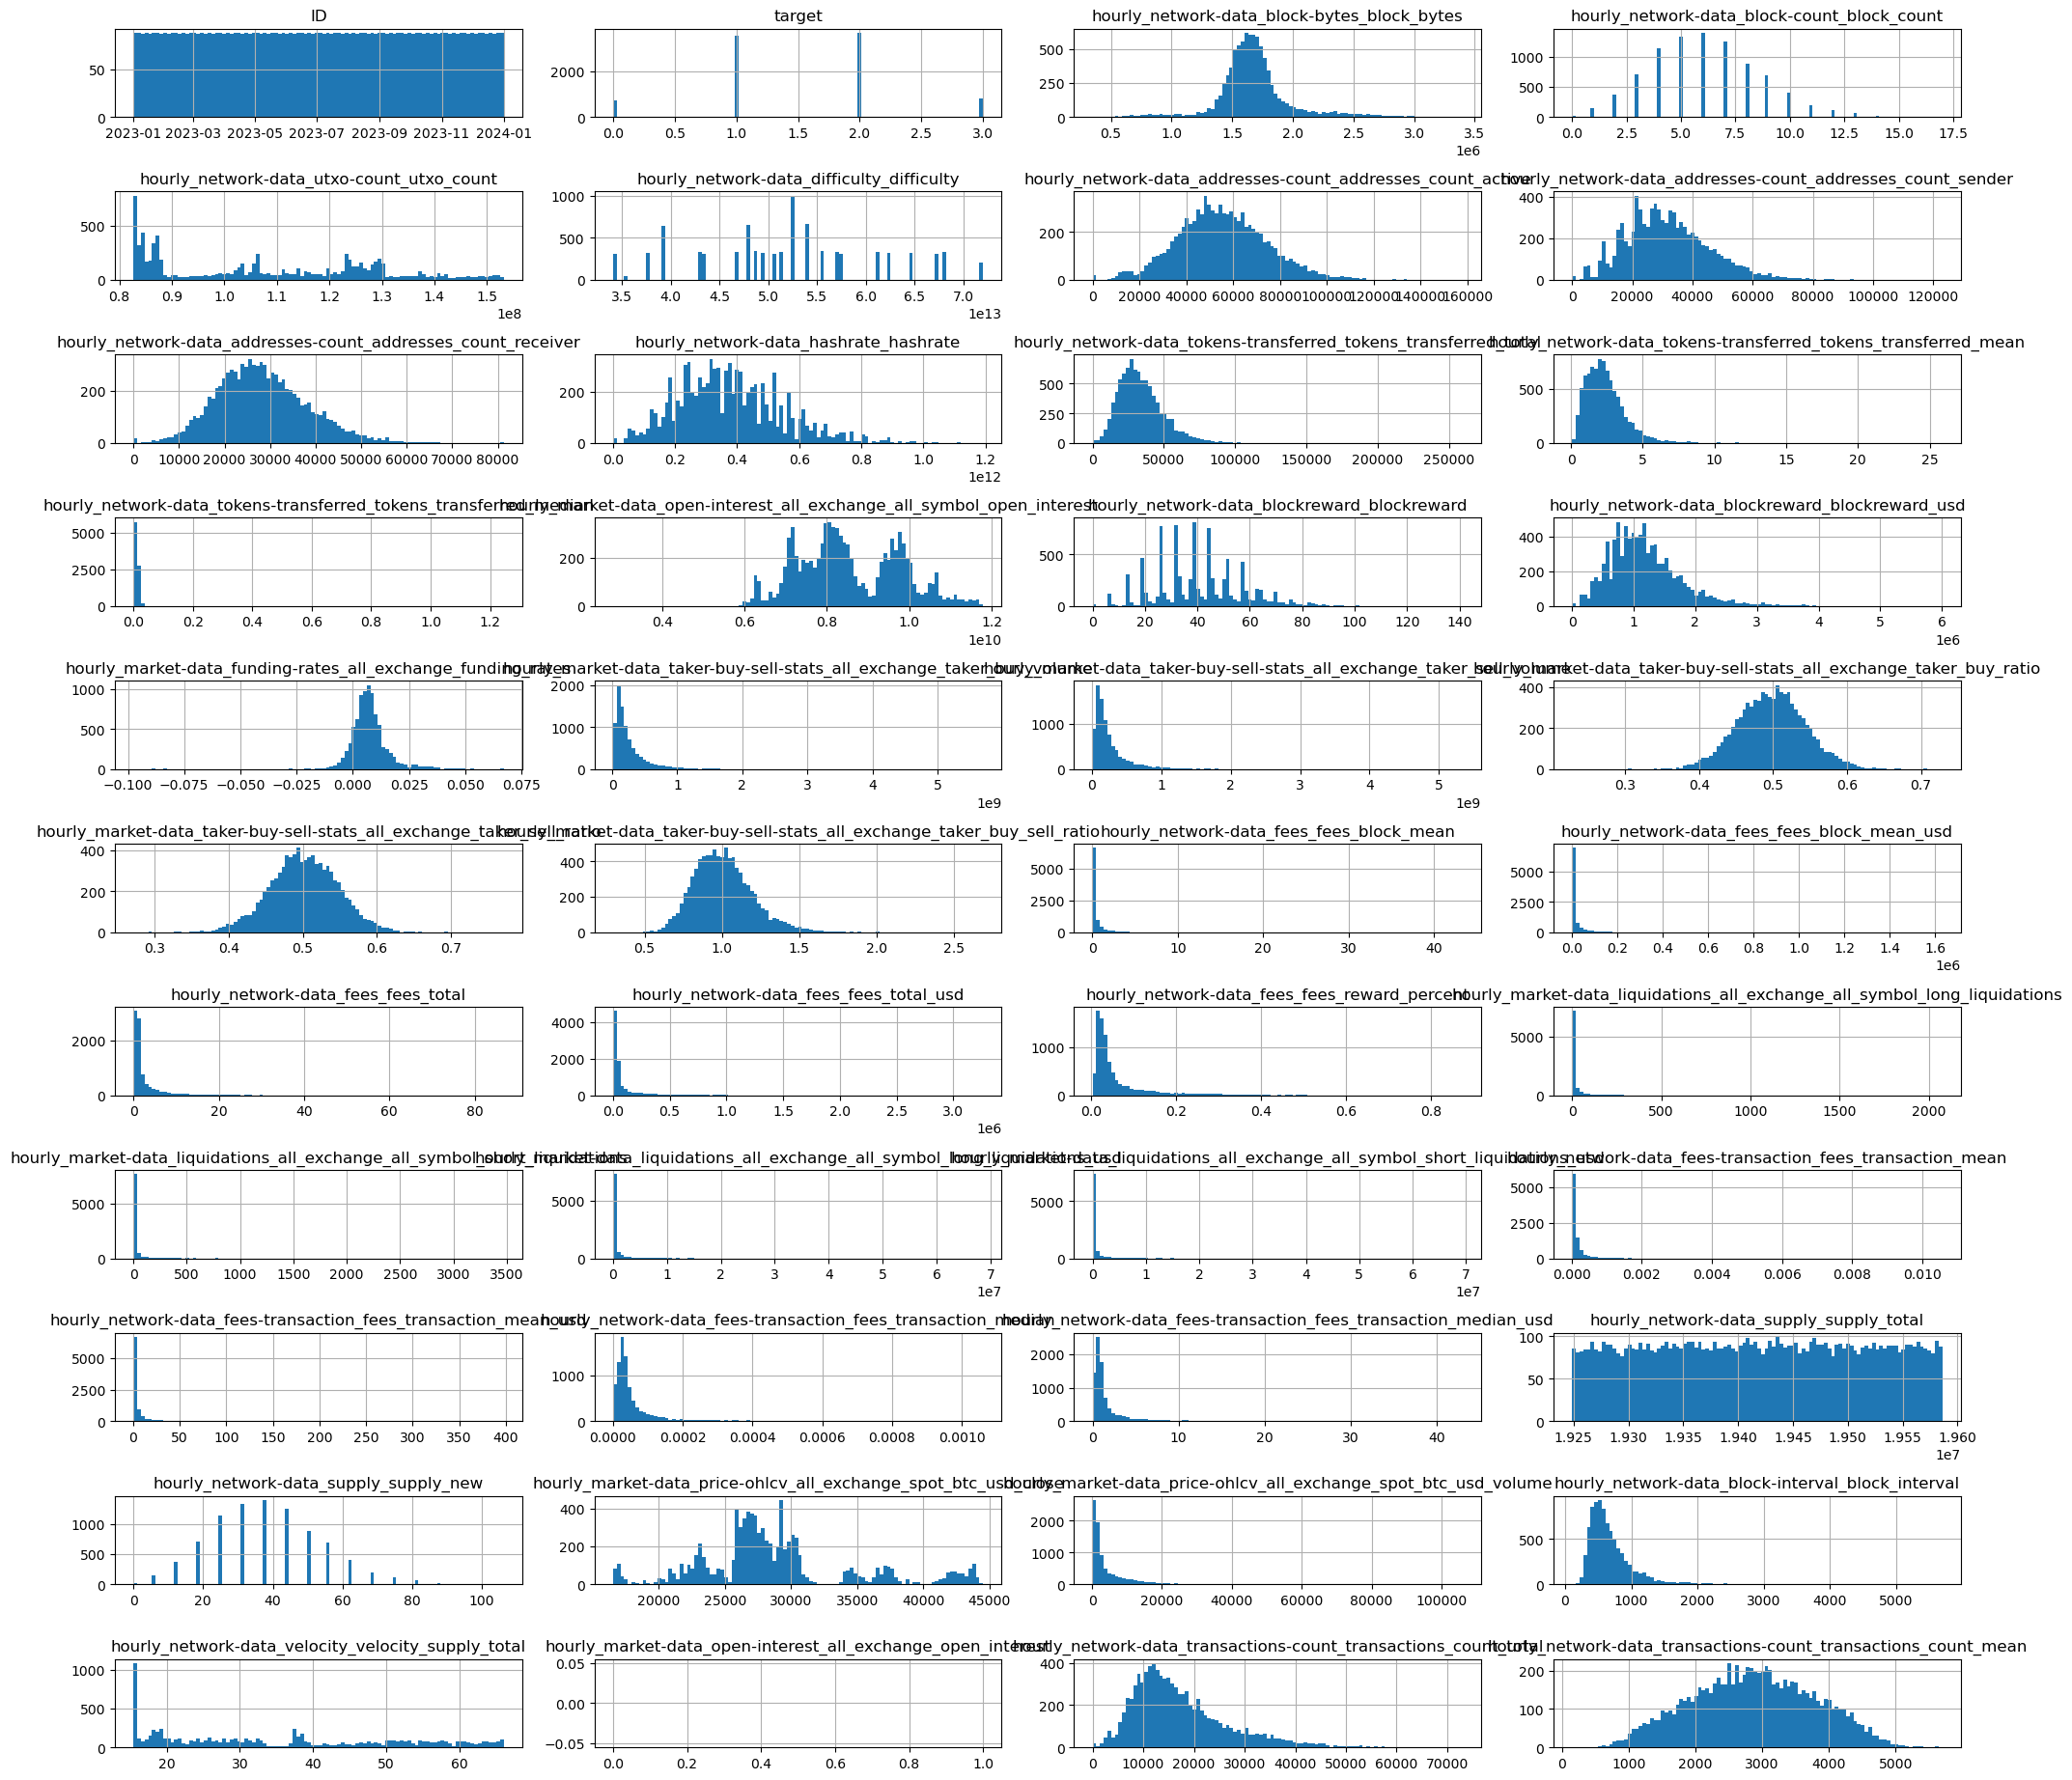

In [156]:
# 피처들의 분포도 확인
df_new.hist(figsize=(20, 20), bins=100, layout=(12, 4))
plt.tight_layout()
plt.show()

In [158]:
# 평균 트랜잭션 가치
df_new['average_transaction_value'] = df_new['hourly_network-data_tokens-transferred_tokens_transferred_total'] / df_new['hourly_network-data_transactions-count_transactions_count_total']
# 네트워크 부하 지표
df_new['network_load'] = df_new['hourly_network-data_block-bytes_block_bytes'] / df_new['hourly_network-data_block-count_block_count']
# 시장 압력 지표
df_new['market_pressure'] = df_new['hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio'] / df_new['hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio']
# 청산 위험 지표
df_new['liquidation_risk'] =  (df_new['hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations'] + df_new['hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations']) / df_new['hourly_market-data_open-interest_all_exchange_all_symbol_open_interest']

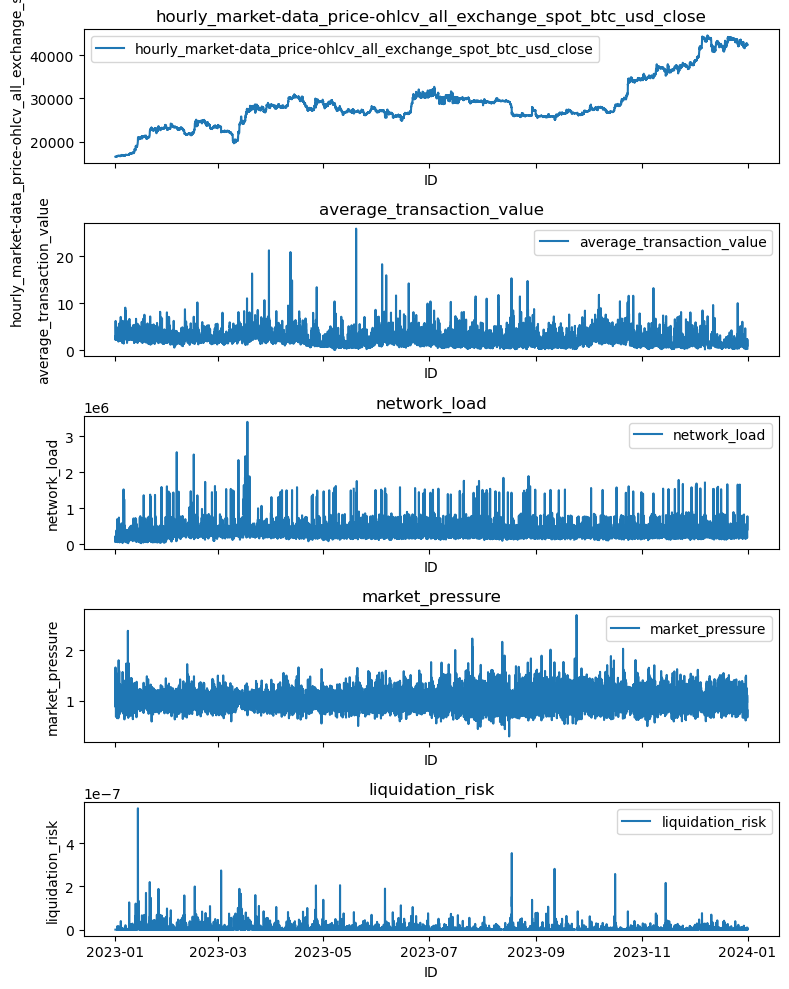

In [161]:
# 'ID'와 'close' 및 새롭게 생성된 피처들을 시각화하는 코드
features_to_plot = ['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 
                    'average_transaction_value',
                    'network_load', 
                    'market_pressure', 
                    'liquidation_risk']

# 서브플롯 생성
fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(8, 10), sharex=True)

# 각 피처를 반복하며 시각화
for i, feature in enumerate(features_to_plot):
    axes[i].plot(df_new['ID'], df_new[feature], label=feature)
    axes[i].set_title(feature)
    axes[i].set_xlabel('ID')
    axes[i].set_ylabel(feature)
    axes[i].legend()

# 그래프 간격 조정
plt.tight_layout()
plt.show()

In [179]:
# 타겟 값 별로 변수의 평균 파익
bar_df = df_new.groupby("target").agg({
        "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "mean",
        'average_transaction_value': "mean",
        'network_load': "mean", 
        'market_pressure': "mean", 
        'liquidation_risk': "mean"
}).reset_index()
bar_df

,target,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,average_transaction_value,network_load,market_pressure,liquidation_risk
0,0.0,29643.533974,2.705302,350141.914730,1.004803,8.415886e-09
1,1.0,28690.376933,2.357934,337246.866895,1.029377,4.051493e-09
2,2.0,28663.459620,2.426077,334975.874418,0.993798,4.411184e-09
3,3.0,29100.590892,2.532341,348842.575984,1.002806,1.040544e-08


In [180]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig: go.Figure = make_subplots(
    rows=8,
    cols=1,
    shared_xaxes=True,
    subplot_titles=(
        'Target distribution',
        'average_transaction_value',
        'network_load', 
        'market_pressure', 
        'liquidation_risk'
    ),
)
# target distribution 시각화
_target_distribution = df_new["target"].value_counts() / len(df_new)
fig.add_trace(
    go.Bar(
        x=_target_distribution.index, 
        y=_target_distribution,
        marker_color='blue'
    ), row=1, col=1
)

fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["average_transaction_value"], marker_color='orange'), row=2, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["network_load"], marker_color='purple'), row=3, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["market_pressure"], marker_color='pink'), row=4, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["liquidation_risk"], marker_color='cyan'), row=5, col=1)

# 레이아웃 업데이트
fig.update_layout(title_text="Target statistics for selected features", showlegend=False, height=800)
fig.update_xaxes(title_text="Target", row=5)
fig.show()


- 데이터의 분포도가 타겟별로 어느정도 구분되긴 하나, 명확하지 않음.
- 이전 인스턴스와의 비교를 통해 생성된 피처의 구분 확인

In [183]:
# 타겟 값 별로 변수의 평균 파익
bar_df = df_new.groupby("target").agg({
        'average_transaction_value_diff': "mean",
        'network_load_diff': "mean", 
        'market_pressure_diff': "mean", 
        'liquidation_risk_diff': "mean"
}).reset_index()
bar_df

,target,average_transaction_value_diff,network_load_diff,market_pressure_diff,liquidation_risk_diff
0,0.0,0.136429,-8173.478572,0.006960,7.431695e-10
1,1.0,-0.038300,1538.785803,0.009930,-6.302680e-11
2,2.0,0.011881,430.169105,-0.008837,-4.400070e-10
3,3.0,-0.039016,3870.124907,-0.009950,1.602092e-09


In [185]:
fig = make_subplots(rows=5, cols=1, shared_xaxes=True, subplot_titles=[
    "Target Distribution",
    "Average Transaction Value Diff",
    "Network Load Diff",
    "Market Pressure Diff",
    "Liquidation Risk Diff"
])

# Target distribution 시각화
_target_distribution = df_new["target"].value_counts() / len(df_new)
fig.add_trace(
    go.Bar(
        x=_target_distribution.index, 
        y=_target_distribution,
    ), row=1, col=1
)

fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["average_transaction_value_diff"], ), row=2, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["network_load_diff"], ), row=3, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["market_pressure_diff"], ), row=4, col=1)
fig.add_trace(go.Bar(x=bar_df["target"], y=bar_df["liquidation_risk_diff"], ), row=5, col=1)

# 레이아웃 업데이트 (높이, 타이틀, 축 레이블 등)
fig.update_layout(
    title_text="Target Statistics for Selected Features", 
    showlegend=False, 
    height=800,  # 전체 그래프 높이
    title_x=0.5   # 타이틀 중앙 정렬
)

# 마지막 X축 레이블 추가
fig.update_xaxes(title_text="Target", row=5, col=1)

# 그래프 출력
fig.show()

- "Average Transaction Value Diff"는 평균 트랜잭션 가치의 차로, 종가 하락률이 클 때 더 많은 고액의 거래가 이뤄지거나(덤핑 예상) 시장이 활발해진다
- "Network Load Diff"는 네트워크 부하의 차이로, 시장이 활발할 때 부하의 변동이 평균적으로 크다.
- "Market Pressure Diff"는 시장 압력 지표의 차이로, 확실히 매수 압력과 매도 압력시 해당 부분이 반영됨을 알 수 있다.
- "Liquidation Rist Diff"는 남아 있는 포지션에 대한 청산된 포지션의 중요성을 나타내는 지표로, 시장 변동성이 클 때 청산량이 많아짐을 알 수 있다.

In [190]:
new_feature_df = df_new[['ID', 'target', 'average_transaction_value', 'network_load', 'market_pressure', 'liquidation_risk', 'average_transaction_value_diff', 'network_load_diff', 'market_pressure_diff', 'liquidation_risk_diff']].copy()

In [192]:
new_feature_df.to_csv(os.path.join(data_path, "new_features.csv"), index=False)